In [1]:
# TODO implementar os demais agentes como partes do cérebro
# TODO integrar no fluxo do langgraph
# TODO testar somente texto
# TODO implementar memória de conversa postgres
# TODO implementar memória da amygdala
# TODO verificar se algum outro ponto deve ter memória

In [2]:
from typing import Annotated



from langchain_experimental.tools import PythonREPLTool
from langchain_community.utilities import GoogleSerperAPIWrapper
from langchain_core.tools import tool
from typing import Literal

from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
# chatPromptTemplate
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

from langchain_openai import ChatOpenAI
from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.llms import OpenAI
from langchain_core.output_parsers import PydanticOutputParser

from pydantic import BaseModel, Field

from agents.src.utils import clean_json
from agents.prefrontal_cortex import prefrontal_cortex_agent
from agents.behavior_planner import behavior_planner_agent
from agents.decision_maker import decision_maker_agent
from agents.social_behavior_modulator import social_behavior_modulator_agent
from agents.complex_thought_planner import complex_thought_planner_agent
from agents.personality_expression_planner import personality_expression_planner_agent

In [3]:
from dotenv import load_dotenv
load_dotenv()

True

## Create tools

In [4]:
search = GoogleSerperAPIWrapper(gl='br', hl='pt-BR', k=3)


@tool
def serper_tool(question: Literal["nyc", "sf"]):
    """Useful for when you need to ask with search"""
    return search.run(question)
    

python_repl_tool = PythonREPLTool()

### Models

In [5]:
model = ChatOpenAI(model="gpt-4o-mini")

In [6]:

# Creating the sixth analysis agent to check the prompt structure
# This print part helps you to trace the graph decisions




# Creating the seventh analysis agent to check the prompt structure
# This print part helps you to trace the graph decisions
template_cortex_out = """
Interaction: {messages}

The Prefrontal Cortex has analyzed the input and distributed the tasks among the agents.
Here are the results:

Behavior Planner: 
- Actual Behavior: {actual_behavior}
- Alternative Behavior: {alternative_behavior}
- Control Mechanisms: {control_mechanisms}
- Contingency Plans: {contingency_plans}

Decision Maker:
- Available Decisions: {available_decisions}
- Implications: {implications}
- Optimal Decision: {optimal_decision}
- Decision Strategy: {decision_strategy}
- Decision Consistency: {decision_consistency}

Social Behavior Modulator:
- Social Behavior: {social_behavior}
- Guidelines: {guidelines}
- Modulator Examples: {examples_modulator}
- Social Estrategy: {social_estrategy}
- Social Consistency: {social_consistency}

Complex Thought Planner:
- Detailed Analysis: {detailed_analysis}
- Standard Relations: {standard_relations}
- Insights: {insights}
- Implications Scenarios: {implications_scenarios}
- Comprehensive Understanding: {comprehensive_understanding}

Personality Expression Planner:
- Personality: {personality}
- Guidelines: {guidelines_personality}
- Personality Examples: {examples_personality}
- Personality Estrategy: {personality_estrategy}
- Personality Consistency: {personality_consistency}

Based on this analysis, answer the interaction.

"""

def cortex_out_agent(state):
    prompt = PromptTemplate(
        template = template_cortex_out,
        input_variables=["messages"]
    )
    chain = prompt | model
    response = chain.invoke({
        "messages": state["messages"],
        #"expected_action": state["expected_action"],
        "actual_behavior": state["actual_behavior"],
        "alternative_behavior": state["alternative_behavior"],
        "control_mechanisms": state["control_mechanisms"],
        "contingency_plans": state["contingency_plans"],
        "available_decisions": state["available_decisions"],
        "implications": state["implications"],
        "optimal_decision": state["optimal_decision"],
        "decision_strategy": state["decision_strategy"],
        "decision_consistency": state["decision_consistency"],
        "social_behavior": state["social_behavior"],
        "guidelines": state["guidelines"],
        "examples_modulator": state["examples_modulator"],
        "social_estrategy": state["social_estrategy"],
        "social_consistency": state["social_consistency"],
        "detailed_analysis": state["detailed_analysis"],
        "standard_relations": state["standard_relations"],
        "insights": state["insights"],
        "implications_scenarios": state["implications_scenarios"],
        "comprehensive_understanding": state["comprehensive_understanding"],
        "personality": state["personality"],
        "guidelines_personality": state["guidelines_personality"],
        "examples_personality": state["examples_personality"],
        "personality_estrategy": state["personality_estrategy"],
        "personality_consistency": state["personality_consistency"]
    })
    state["messages"] = response
    return {"messages": state["messages"]}

In [7]:

from langgraph.graph import StateGraph, END
from typing import Annotated, TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph.message import add_messages

#from agents import analyze_question, answer_code_question, answer_generic_question

#You can precise the format here which could be helpfull for multimodal graphs
class AgentState(TypedDict):
    #input: str
    #output: str
    messages: Annotated[list, add_messages]
    behavior_planner: str
    decision_maker: str
    social_behavior_modulator: str
    complex_thought_planner: str
    personality_expression_planner: str
    actual_behavior: str
    alternative_behavior: str
    control_mechanisms: str
    contingency_plans: str
    available_decisions: str
    implications: str
    optimal_decision: str
    decision_strategy: str
    decision_consistency: str
    social_behavior: str
    guidelines: str
    examples_personality: str
    examples_modulator: str
    social_estrategy: str
    social_consistency: str
    personality_estrategy: str
    personality_consistency: str
    detailed_analysis: str
    standard_relations: str
    insights: str
    implications_scenarios: str
    comprehensive_understanding: str
    personality: str
    guidelines_personality: str


#Here is a simple 3 steps graph that is going to be working in the bellow "decision" condition
workflow = StateGraph(AgentState)

workflow.add_node("prefrontal_cortex_agent", prefrontal_cortex_agent)
workflow.add_node("behavior_planner_agent", behavior_planner_agent)
workflow.add_node("decision_maker_agent", decision_maker_agent)
workflow.add_node("social_behavior_modulator_agent", social_behavior_modulator_agent)
workflow.add_node("complex_thought_planner_agent", complex_thought_planner_agent)
workflow.add_node("personality_expression_planner_agent", personality_expression_planner_agent)
workflow.add_node("prefrontal_cortex_out_agent", cortex_out_agent)
#workflow.add_node("generic_agent", answer_generic_question)

#workflow.add_conditional_edges(
#    "analyze",
#    lambda x: x["decision"],
#    {
#        "code": "code_agent",
#        "general": "generic_agent"
#    }
#)

workflow.set_entry_point("prefrontal_cortex_agent")
workflow.add_edge("prefrontal_cortex_agent", "behavior_planner_agent")
workflow.add_edge("prefrontal_cortex_agent", "decision_maker_agent")
workflow.add_edge("prefrontal_cortex_agent", "social_behavior_modulator_agent")
workflow.add_edge("prefrontal_cortex_agent", "complex_thought_planner_agent")
workflow.add_edge("prefrontal_cortex_agent", "personality_expression_planner_agent")
workflow.add_edge(["behavior_planner_agent","decision_maker_agent", "social_behavior_modulator_agent", "complex_thought_planner_agent", "personality_expression_planner_agent"], "prefrontal_cortex_out_agent")
workflow.add_edge("prefrontal_cortex_out_agent", END)

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

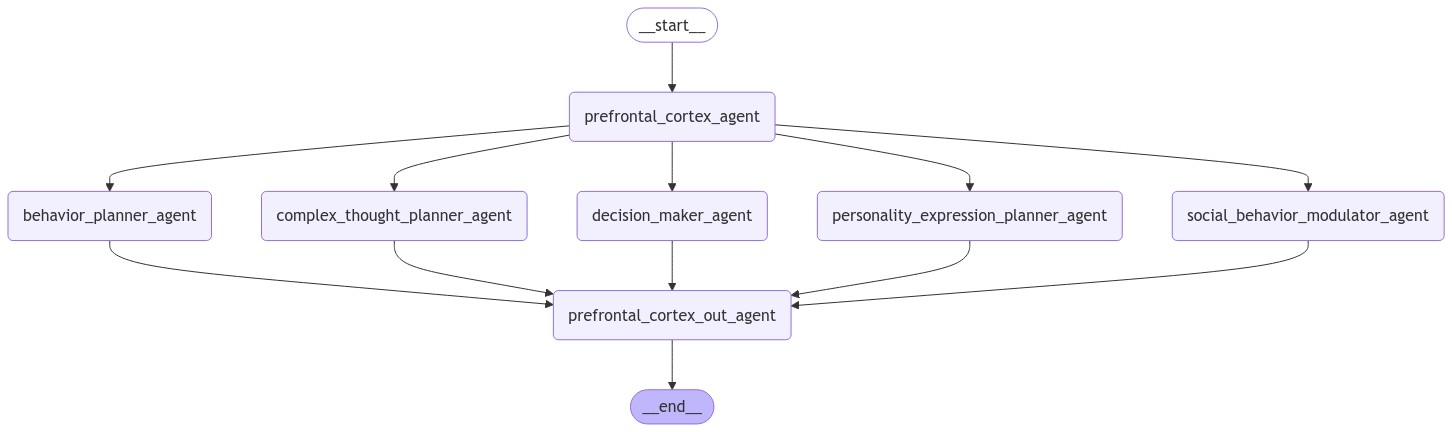

In [8]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [11]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}

for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Oi, meu nome é Cristian!")
        ]
    },
    config
):
    if "__end__" not in s:
        print(s)
        print("----")


{'prefrontal_cortex_agent': {'behavior_planner': 'Preparar uma resposta que inclua uma saudação de volta e uma pergunta sobre os interesses de Cristian.', 'decision_maker': 'Decidir se a conversa deve ser mais informal ou formal, dependendo do tom da mensagem de Cristian.', 'social_behavior_modulator': 'Ajustar o tom da resposta para refletir uma abordagem amigável e receptiva.', 'complex_thought_planner': 'Considerar possíveis tópicos de interesse que podem ser explorados com Cristian, como hobbies ou experiências compartilhadas.', 'personality_expression_planner': 'Incorporar elementos que reflitam uma personalidade aberta e acolhedora na resposta.'}}
----
{'personality_expression_planner_agent': {'examples_personality': 'Oi, Cristian! É um prazer te conhecer! Como você está hoje? Estou aqui para ajudar no que você precisar.', 'personality_estrategy': 'Incorporar linguagem inclusiva e amigável, além de manter um tom otimista e encorajador nas interações.', 'personality_consistency': 

In [12]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}

for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Qual meu nome?")
        ]
    },
    config
):
    if "__end__" not in s:
        print(s)
        print("----")


{'prefrontal_cortex_agent': {'behavior_planner': 'Preparar uma resposta que inclua o nome do humano e uma pergunta adicional para manter a conversa fluindo.', 'decision_maker': 'Selecionar a resposta que melhor se alinha ao tom amigável e acolhedor da interação.', 'social_behavior_modulator': 'Ajustar o comportamento para ser mais interativo, incentivando o humano a compartilhar mais sobre si mesmo.', 'complex_thought_planner': 'Analisar o contexto da conversa para entender a relevância de perguntas relacionadas ao nome e hobbies do humano.', 'personality_expression_planner': 'Expressar empatia e interesse genuíno na resposta, utilizando um tom caloroso e amigável.'}}
----
{'behavior_planner_agent': {'actual_behavior': 'Responder ao Cristian mencionando seu nome e fazendo uma pergunta adicional para manter a conversa fluindo.', 'alternative_behavior': 'Ignorar a pergunta do Cristian e mudar de assunto sem mencionar seu nome.', 'control_mechanisms': 'Monitorar a resposta do Cristian par

## Invoke the team

With the graph created, we can now invoke it and see how it performs!


In [16]:
from langchain_core.messages import HumanMessage

for s in graph.stream(
    {
        "messages": [
            HumanMessage(content="Estou com alguns problemas, você pode me ajudar?")
        ]
    }
):
    if "__end__" not in s:
        print(s)
        print("----")

{'agent': {'messages': [AIMessage(content='Claro! Estou aqui para ajudar. Quais problemas você está enfrentando?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 16, 'prompt_tokens': 207, 'total_tokens': 223, 'completion_tokens_details': {'reasoning_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_1bb46167f9', 'finish_reason': 'stop', 'logprobs': None}, id='run-3f3bfdb1-bfe1-4e67-b6f9-fa7b5cda9bf8-0', usage_metadata={'input_tokens': 207, 'output_tokens': 16, 'total_tokens': 223})]}}
----


In [ ]:
for s in graph.stream(
    {"messages": [HumanMessage(content="Estou com alguns problemas, você pode me ajudar?")]},
    {"recursion_limit": 5},
):
    if "__end__" not in s:
        print(s)
        print("----")

In [15]:
def print_stream(stream):
    for s in stream:
        message = s["messages"][-1]
        if isinstance(message, tuple):
            print(message)
        else:
            message.pretty_print()

inputs = {"messages": [("user", "Estou com alguns problemas, você pode me ajudar?")]}

print_stream(graph.stream(inputs, stream_mode="values"))

================================ Human Message =================================

Estou com alguns problemas, você pode me ajudar?
================================== Ai Message ==================================

Claro! Estou aqui para ajudar. Quais problemas você está enfrentando?
